# Калибровка

## Загрузка данных и обучение модели

### библиотека и импорты

In [1]:
# !rm library/fgb -r
# !rm fgb -r

In [2]:
!mkdir library
!git clone https://gitlab.com/gini-bearers/fgb.git
!mv fgb library

mkdir: cannot create directory ‘library’: File exists
fatal: destination path 'fgb' already exists and is not an empty directory.
mv: cannot move 'fgb' to 'library/fgb': Directory not empty


In [3]:
import sys
sys.path.append('./library/fgb')
import importlib

In [4]:
pip install optbinning

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import seaborn as sns

from fgb.functions_layer.calibration import calibration_class
from fgb.functions_layer.calibration import score_binning_class

(CVXPY) Sep 09 04:05:40 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 09 04:05:40 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


### создание выборки

In [6]:
X, y = make_classification(random_state=42, n_samples=100000, n_features=20, n_informative=15, weights=[0.2], flip_y=0.20)
X.shape

(100000, 20)

In [7]:
df = pd.DataFrame(X)
df['target'] = y

print(df['target'].value_counts())

target
1    73972
0    26028
Name: count, dtype: int64


In [8]:
df

0         1         2         3         4         5          6  \
0     -0.412283 -2.094615 -0.308031 -0.906262  1.757685  0.265375  -4.786740   
1     -0.647899 -1.876813  1.125149 -3.654667  1.968079 -2.369411  -0.535609   
2     -0.117495 -4.163368  0.805867 -0.344336 -2.283297 -2.214516   0.068893   
3     -1.506819 -4.510987  1.410326 -1.094766  1.242533  0.316413  -3.704172   
4      1.300282 -4.109677  0.226892  3.961362  1.711816 -3.116667 -10.350803   
...         ...       ...       ...       ...       ...       ...        ...   
99995  0.120509  0.309896 -0.212869  0.747142  3.615325 -1.252951 -11.824857   
99996 -0.836527  0.829314  0.371044  2.117054  0.730714 -0.627957  -5.289528   
99997  1.550634 -0.727463  0.570509  0.246140  1.845675 -1.036390  -0.851713   
99998 -0.560058  1.707789 -1.953028 -3.167152  1.139255 -2.717303   0.357574   
99999  0.686608 -0.146160  1.701893  1.278131 -1.251141 -1.565543   3.070411   

              7         8         9  ...        11        12        13  \
0     -2.178313 -0.010771 -0.870159  ... -0.159874 -0.568871 -3.968395   
1     -1.253748 -0.953069 -1.537580  ...  0.104299  1.874633 -2.028011   
2     -4.814240 -1.352087 -3.009147  ... -0.711091 -2.607996 -1.905002   
3      2.204225  2.638172  1.482277  ...  0.877311 -1.962279 -2.721519   
4      4.768438  1.448626  0.854252  ... -0.050734 -0.253440 -0.006478   
...         ...       ...       ...  ...       ...       ...       ...   
99995 -0.454595  3.097214  0.265647  ... -0.482471  1.835123  0.946119   
99996  6.343366 -2.377567 -1.959988  ...  0.108474  0.200787  0.440030   
99997  1.169166 -1.252394  0.190475  ... -0.329524 -2.262385 -1.662349   
99998  0.398106 -3.365372  0.652133  ...  1.160107  0.526169  0.571853   
99999 -2.799534  0.730155  3.975238  ... -0.257765  3.121707 -1.343399   

             14        15        16        17        18        19  target  
0     -0.178245  4.075690  2.708369 -0.012512  0.993115 -0.897847       1  
1     -0.735889 -2.395763  3.023122  1.965528  0.186679 -2.342171       1  
2      1.993757  1.559879  4.458719 -4.100227 -2.089781 -0.890565       1  
3     -2.442446 -3.006711  2.041901  2.257844  4.189803 -3.461170       1  
4      0.590637  1.848974 -0.085436 -0.529271  6.081738 -3.983690       1  
...         ...       ...       ...       ...       ...       ...     ...  
99995  2.478739  2.856184  0.742817 -1.597946 -3.772247 -0.432946       0  
99996 -1.285405  1.606287 -0.767319 -0.118807  9.447837 -1.986893       1  
99997  1.683948 -1.870555  1.956690  0.542443  2.547501  0.203594       1  
99998  2.522492  3.397425 -1.225730 -0.312448  0.904112 -1.833966       0  
99999  3.577689 -0.451611 -0.609264  2.622218 -2.347030  1.407023       1  

[100000 rows x 21 columns]

In [9]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

df.loc[train.index, 'set_type'] = 'train'
df.loc[test.index, 'set_type'] = 'test'

In [10]:
features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

### обучение

In [11]:
rfc = RandomForestClassifier(
        max_depth=2, n_estimators=200, random_state=42
)

In [12]:
rfc.fit(df[df['set_type'] == 'train'][features], df[df['set_type'] == 'train']['target'])

RandomForestClassifier(max_depth=2, n_estimators=200, random_state=42)

In [13]:
df['score'] = rfc.predict_log_proba(df[features])[:,1]

### gini на подсетах

In [14]:
roc_auc_score(df[df['set_type'] == 'train']['target'], df[df['set_type'] == 'train']['score']) * 2 - 1

0.5070343912982584

In [15]:
roc_auc_score(df[df['set_type'] == 'test']['target'], df[df['set_type'] == 'test']['score']) * 2 - 1

0.5063926614655656

<Axes: xlabel='score', ylabel='Density'>

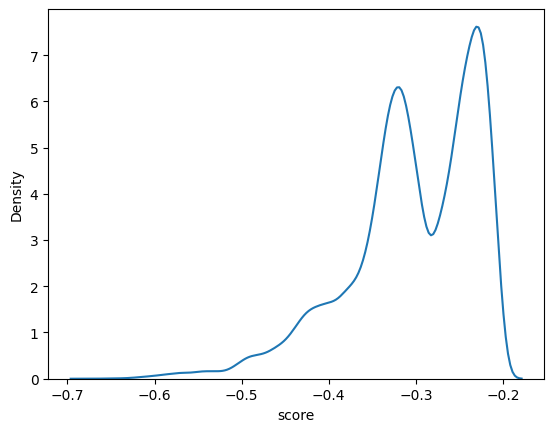

In [16]:
sns.kdeplot(df['score'])

<Axes: >

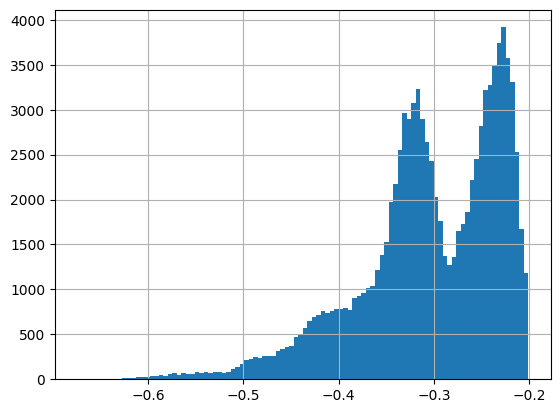

In [17]:
df['score'].hist(bins=100)

## Сама калибровка
### Изотоническое разбиение(находим минимальное монотонное разбиение скора по таргету)

In [18]:
from sklearn.isotonic import IsotonicRegression

clb_set - это сет на котором производится калибровка, в зависимости от задачи это может быть:

1.   Выборка выданная аналитиками
2.   Весь датасет
3.   Подсет с наиболее современными данными

и т.д.

в общем случае он должен удовлетворять двум требованиям:

1.   Быть достаточно большим, для того чтобы можно было считать статистически значимой
2.   Соотвествовать тому потоку, что будет на проде

в примере выбран train, но это просто для примера

In [19]:
clb_set = df[df['set_type'] == 'train']

score_binning_ = score_binning_class.score_binning(clb_set = clb_set,
                               target_name = 'target',
                               target_prev_name = 'target',
                               score_name = 'score')

score_binning_.isotonic_bins(target_type = 'target', y_min = 0.001, y_max = 0.9, bins_save_name = 'isot_bins', increasing = 'auto', out_of_bounds = 'clip')

In [20]:
score_binning_.build_bins_table('isot_bins')

isot_bins  bin_size     score                           target        \
                             min       max      mean count  count   sum   
0   0.001000  0.000063 -0.673970 -0.657008 -0.665963     5      5     0   
1   0.041667  0.000300 -0.653772 -0.622644 -0.634191    24     24     1   
2   0.071429  0.000350 -0.621867 -0.611050 -0.615439    28     28     2   
3   0.088235  0.000850 -0.610980 -0.596354 -0.603464    68     68     6   
4   0.105169  0.007012 -0.596196 -0.540482 -0.564658   561    561    59   
..       ...       ...       ...       ...       ...   ...    ...   ...   
85  0.895131  0.006675 -0.223046 -0.222206 -0.222620   534    534   478   
86  0.895149  0.007987 -0.222205 -0.221062 -0.221640   639    639   572   
87  0.896552  0.000362 -0.221060 -0.221034 -0.221044    29     29    26   
88  0.898974  0.054813 -0.221034 -0.212810 -0.217185  4385   4385  3942   
89  0.900000  0.041063 -0.212810 -0.200901 -0.207822  3285   3285  2988   

              
        mean  
0   0.000000  
1   0.041667  
2   0.071429  
3   0.088235  
4   0.105169  
..       ...  
85  0.895131  
86  0.895149  
87  0.896552  
88  0.898974  
89  0.909589  

[90 rows x 9 columns]

### теперь объединяем бины полученные на прошлом шаге с помощью optbinning

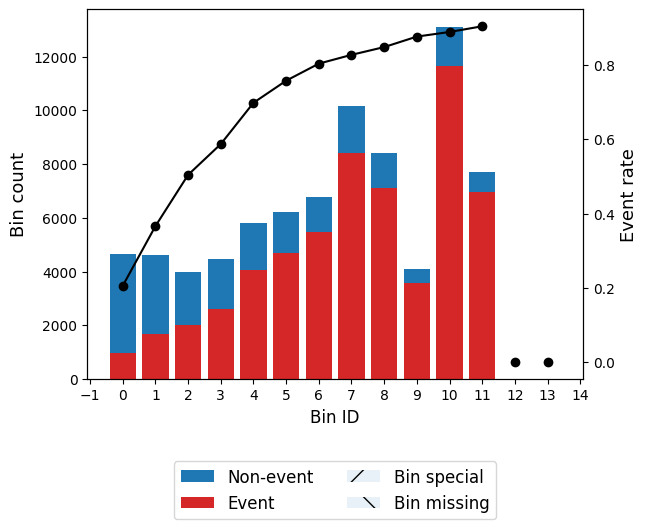

In [21]:
bt, optb = score_binning_.optb_bins(target_type = 'target',
                                    min_bin_n_event = 10,
                                    min_bin_n_nonevent = 100,
                                    min_event_rate_diff = 0.01,
                                    min_bin_size = 0.05,
                                    bins_save_name = 'optb_bins_0',
                                    user_splits_table = score_binning_.build_bins_table('isot_bins'))

In [22]:
bt

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, -0.44)   4665   0.058313       3705    960    0.205788   
1       [-0.44, -0.40)   4632   0.057900       2936   1696    0.366149   
2       [-0.40, -0.37)   4000   0.050000       1984   2016    0.504000   
3       [-0.37, -0.35)   4453   0.055662       1840   2613    0.586795   
4       [-0.35, -0.33)   5797   0.072462       1752   4045    0.697775   
5       [-0.33, -0.32)   6206   0.077575       1507   4699    0.757170   
6       [-0.32, -0.31)   6793   0.084913       1338   5455    0.803033   
7       [-0.31, -0.27)  10179   0.127238       1764   8415    0.826702   
8       [-0.27, -0.25)   8396   0.104950       1280   7116    0.847546   
9       [-0.25, -0.24)   4081   0.051013        507   3574    0.875766   
10      [-0.24, -0.22)  13099   0.163738       1465  11634    0.888159   
11        [-0.22, inf)   7699   0.096238        743   6956    0.903494   
12             Special      0   0.000000          0      0    0.000000   
13             Missing      0   0.000000          0      0    0.000000   
Totals                  80000   1.000000      20821  59179    0.739738   

             WoE        IV        JS  
0        2.39511  0.387345  0.039397  
1        1.59338  0.179021  0.020275  
2       1.028604  0.062973  0.007542  
3       0.693871  0.030682  0.003760  
4       0.207881  0.003283  0.000410  
5      -0.092624  0.000651  0.000081  
6      -0.360752  0.010071  0.001252  
7      -0.517827  0.029761  0.003679  
8      -0.670881  0.039427  0.004838  
9      -0.908325  0.032738  0.003957  
10     -1.027472  0.129696  0.015535  
11     -1.192059  0.097578  0.011523  
12           0.0  0.000000  0.000000  
13           0.0  0.000000  0.000000  
Totals            1.003226  0.112249

In [23]:
df['optb_bins_0'] = optb.transform(df['score'])

## калибруем

In [24]:
grade_groups = {}

calib = calibration_class.calibration(clb_set = score_binning_.clb_set,
                    effects_set = df[df['set_type'] == 'test'],
                    target_name = 'target',
                    score_name = 'score',
                    score_bins_name = 'optb_bins_0',
                    grade_groups = grade_groups)

In [25]:
gr_score = calib.calc_calib(parity = 1, cut_off_dr=0.9)

In [26]:
gr_score

score_bin  min_score  max_score    cnt  bad_sum        dr  real_grade  \
0    2.395110  -0.673970  -0.437087   4665      960  0.205788         100   
1    1.593380  -0.437081  -0.398293   4632     1696  0.366149         100   
2    1.028604  -0.398287  -0.370673   4000     2016  0.504000         100   
3    0.693871  -0.370671  -0.349275   4453     2613  0.586795         100   
4    0.207881  -0.349269  -0.333275   5797     4045  0.697775         100   
5   -0.092624  -0.333272  -0.320871   6206     4699  0.757170         100   
6   -0.360752  -0.320862  -0.307568   6793     5455  0.803033         100   
7   -0.517827  -0.307568  -0.273511  10179     8415  0.826702         100   
8   -0.670881  -0.273510  -0.250043   8396     7116  0.847546         100   
9   -0.908325  -0.250040  -0.242550   4081     3574  0.875766         100   
10  -1.027472  -0.242546  -0.221062  13099    11634  0.888159         100   
11  -1.192059  -0.221060  -0.200901   7699     6956  0.903494         100   

    score_mean  dr_scaled  dr_y_scaled         x  score_mean_cut_off  \
0    -0.487327   0.205788     1.350505 -0.188024           -0.231512   
1    -0.416830   0.366149     0.548776 -0.117528           -0.231512   
2    -0.383769   0.504000    -0.016000 -0.084466           -0.231512   
3    -0.359033   0.586795    -0.350733 -0.059731           -0.231512   
4    -0.340669   0.697775    -0.836724 -0.041366           -0.231512   
5    -0.327077   0.757170    -1.137229 -0.027774           -0.231512   
6    -0.314460   0.803033    -1.405357 -0.015158           -0.231512   
7    -0.292799   0.826702    -1.562432  0.006504           -0.231512   
8    -0.260642   0.847546    -1.715486  0.038661           -0.231512   
9    -0.246160   0.875766    -1.952930  0.053142           -0.231512   
10   -0.231512   0.888159    -2.072077  0.067791           -0.231512   
11   -0.213204   0.903494    -2.236664  0.086098           -0.231512   

    bin_pd_clb  bin_parity  bin_parity_scaled  parity_issued  
0     0.206125    0.998362           0.998362              1  
1     0.412387    0.887876           0.887876              1  
2     0.528024    0.954502           0.954502              1  
3     0.613277    0.956820           0.956820              1  
4     0.672637    1.037372           1.037372              1  
5     0.713377    1.061388           1.061388              1  
6     0.748344    1.073080           1.073080              1  
7     0.801441    1.031520           1.031520              1  
8     0.863998    0.980959           0.980959              1  
9     0.886266    0.988152           0.988152              1  
10    0.905489    0.980861           0.980861              1  
11    0.925393    0.976335           0.976335              1

/content/./library/fgb/fgb/functions_layer/calibration/calibration_class.py:364: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(gr_score.score_mean.round(2))


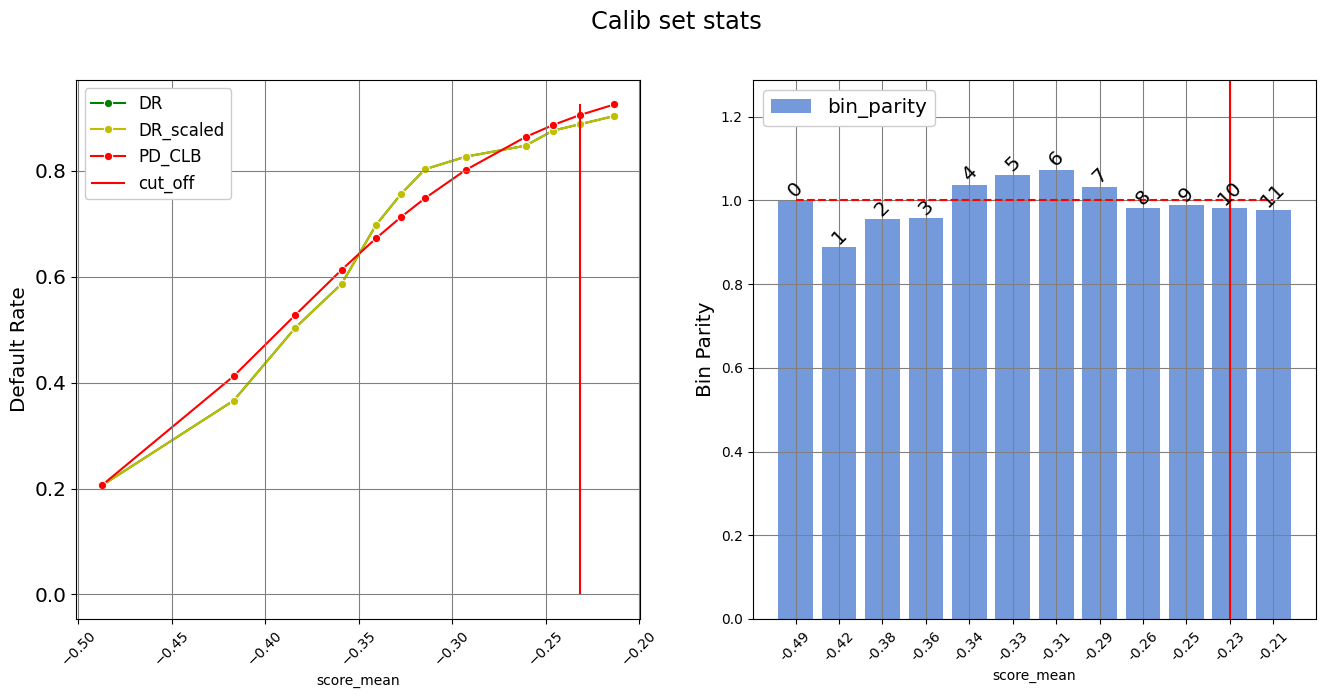

In [27]:
calib.plot_clb_building(gr_score)

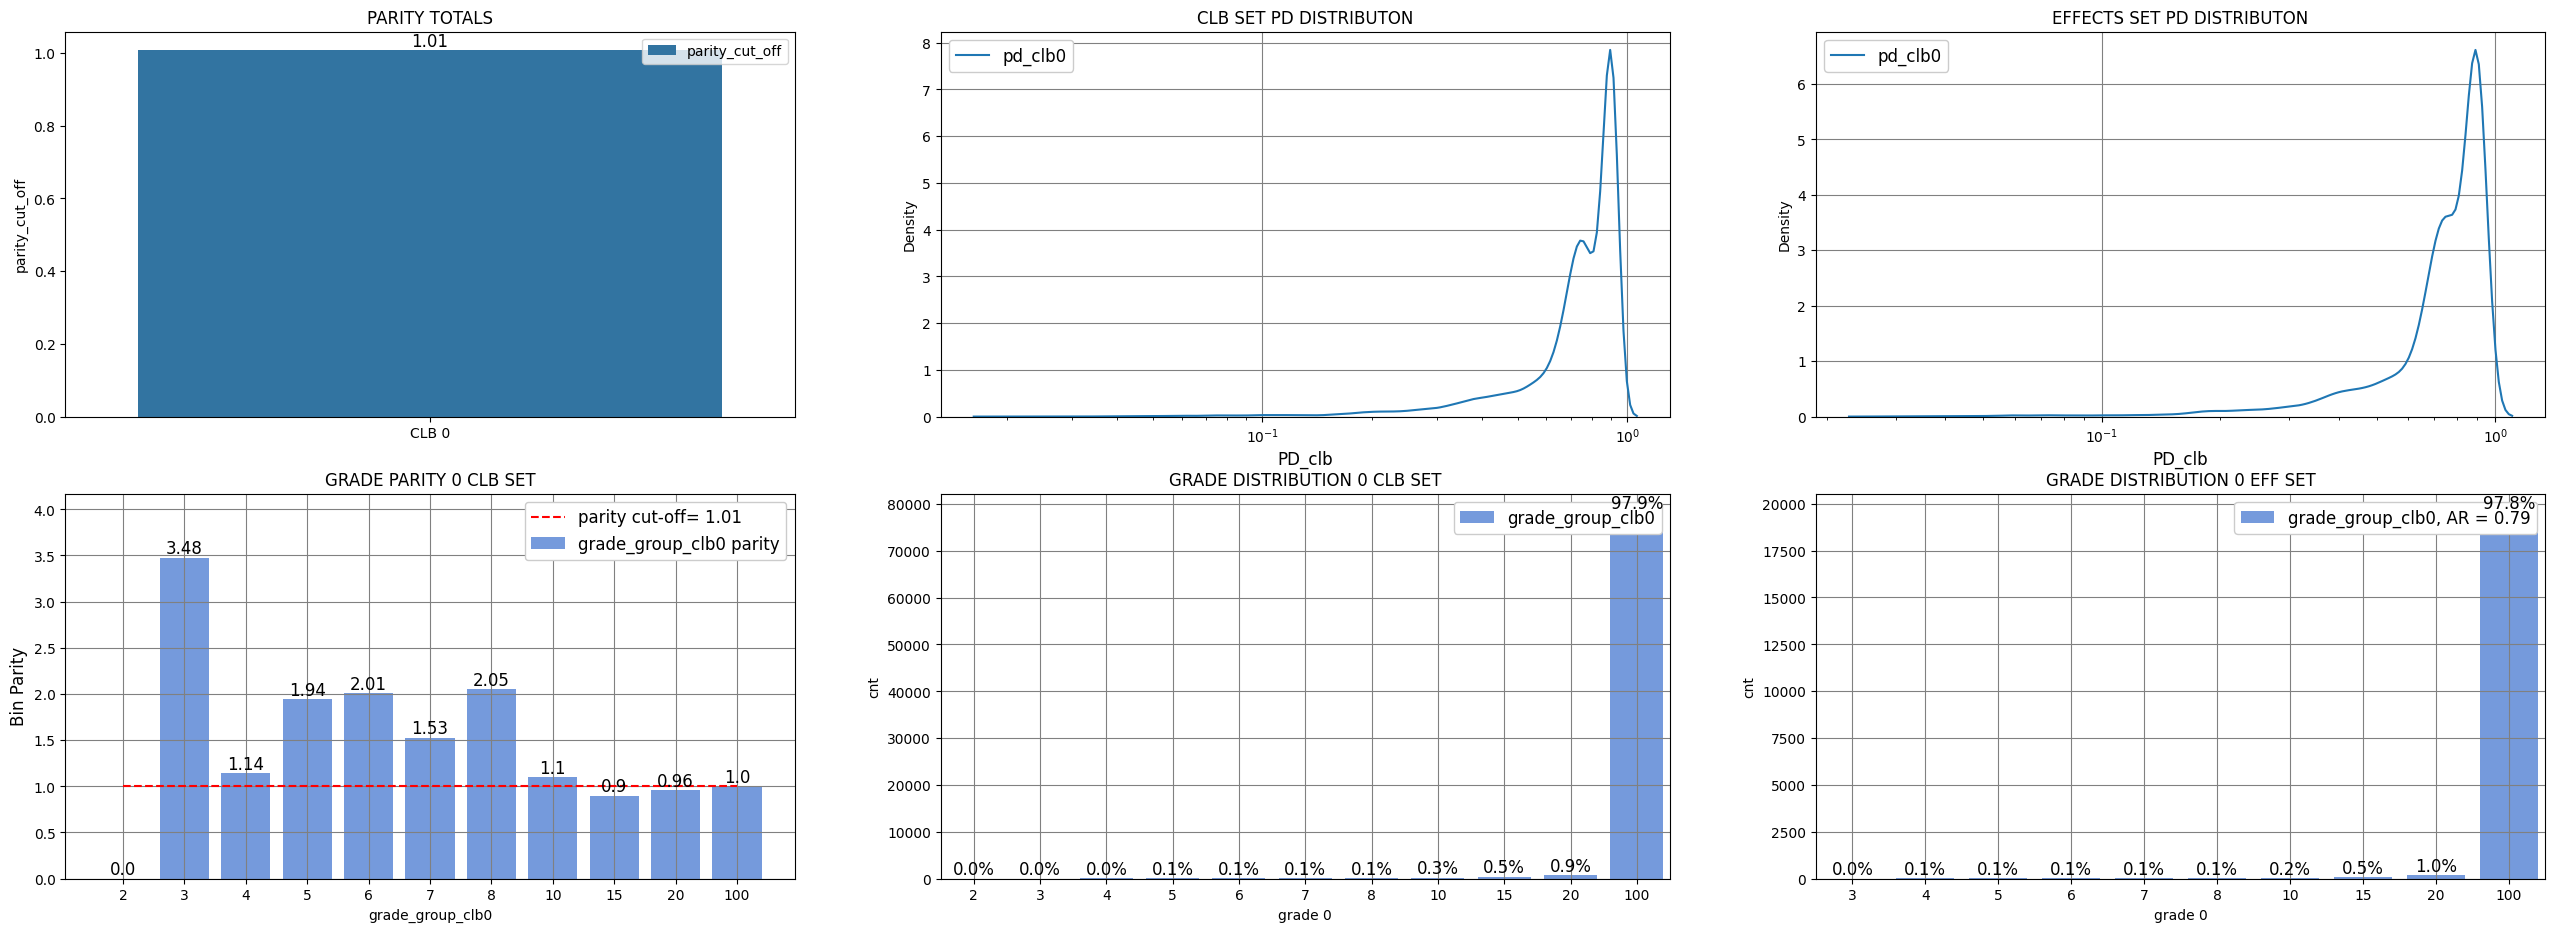

In [28]:
calib.plot_results([0])

### видим что грейдовка для оценки не очень подходит, воспользуемся не той что по умолчанию

In [29]:
def get_grade(x):
        if x < 0.1:
            return "0"
        elif x < 0.2:
            return "1"
        elif x < 0.3:
            return "2"
        elif x < 0.4:
            return "3"
        elif x < 0.5:
            return "4"
        elif x < 0.6:
            return "5"
        elif x < 0.7:
            return "6"
        elif x < 0.8:
            return "7"
        elif x < 0.9:
            return "8"
        elif x >= 0.9:
            return "9-10"
        else:
            return -1


grade_groups = {}

calib = calibration_class.calibration(clb_set = score_binning_.clb_set,
                    effects_set = df[df['set_type'] == 'test'],
                    target_name = 'target',
                    score_name = 'score',
                    score_bins_name = 'optb_bins_0',
                    grade_groups = grade_groups, grade_function = get_grade)

In [30]:
gr_score = calib.calc_calib(parity = 1, cut_off_dr=0.9)

/content/./library/fgb/fgb/functions_layer/calibration/calibration_class.py:123: RuntimeWarning: invalid value encountered in scalar divide
  ,'parity_cut_off' : real_bads_cut_off / model_bads_cut_off


In [31]:
gr_score

score_bin  min_score  max_score    cnt  bad_sum        dr real_grade  \
0    2.395110  -0.673970  -0.437087   4665      960  0.205788          2   
1    1.593380  -0.437081  -0.398293   4632     1696  0.366149          3   
2    1.028604  -0.398287  -0.370673   4000     2016  0.504000          5   
3    0.693871  -0.370671  -0.349275   4453     2613  0.586795          5   
4    0.207881  -0.349269  -0.333275   5797     4045  0.697775          6   
5   -0.092624  -0.333272  -0.320871   6206     4699  0.757170          7   
6   -0.360752  -0.320862  -0.307568   6793     5455  0.803033          8   
7   -0.517827  -0.307568  -0.273511  10179     8415  0.826702          8   
8   -0.670881  -0.273510  -0.250043   8396     7116  0.847546          8   
9   -0.908325  -0.250040  -0.242550   4081     3574  0.875766          8   
10  -1.027472  -0.242546  -0.221062  13099    11634  0.888159          8   
11  -1.192059  -0.221060  -0.200901   7699     6956  0.903494       9-10   

    score_mean  dr_scaled  dr_y_scaled         x  score_mean_cut_off  \
0    -0.487327   0.205788     1.350505 -0.188024           -0.231512   
1    -0.416830   0.366149     0.548776 -0.117528           -0.231512   
2    -0.383769   0.504000    -0.016000 -0.084466           -0.231512   
3    -0.359033   0.586795    -0.350733 -0.059731           -0.231512   
4    -0.340669   0.697775    -0.836724 -0.041366           -0.231512   
5    -0.327077   0.757170    -1.137229 -0.027774           -0.231512   
6    -0.314460   0.803033    -1.405357 -0.015158           -0.231512   
7    -0.292799   0.826702    -1.562432  0.006504           -0.231512   
8    -0.260642   0.847546    -1.715486  0.038661           -0.231512   
9    -0.246160   0.875766    -1.952930  0.053142           -0.231512   
10   -0.231512   0.888159    -2.072077  0.067791           -0.231512   
11   -0.213204   0.903494    -2.236664  0.086098           -0.231512   

    bin_pd_clb  bin_parity  bin_parity_scaled  parity_issued  
0     0.206125    0.998362           0.998362              1  
1     0.412387    0.887876           0.887876              1  
2     0.528024    0.954502           0.954502              1  
3     0.613277    0.956820           0.956820              1  
4     0.672637    1.037372           1.037372              1  
5     0.713377    1.061388           1.061388              1  
6     0.748344    1.073080           1.073080              1  
7     0.801441    1.031520           1.031520              1  
8     0.863998    0.980959           0.980959              1  
9     0.886266    0.988152           0.988152              1  
10    0.905489    0.980861           0.980861              1  
11    0.925393    0.976335           0.976335              1

/content/./library/fgb/fgb/functions_layer/calibration/calibration_class.py:364: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(gr_score.score_mean.round(2))


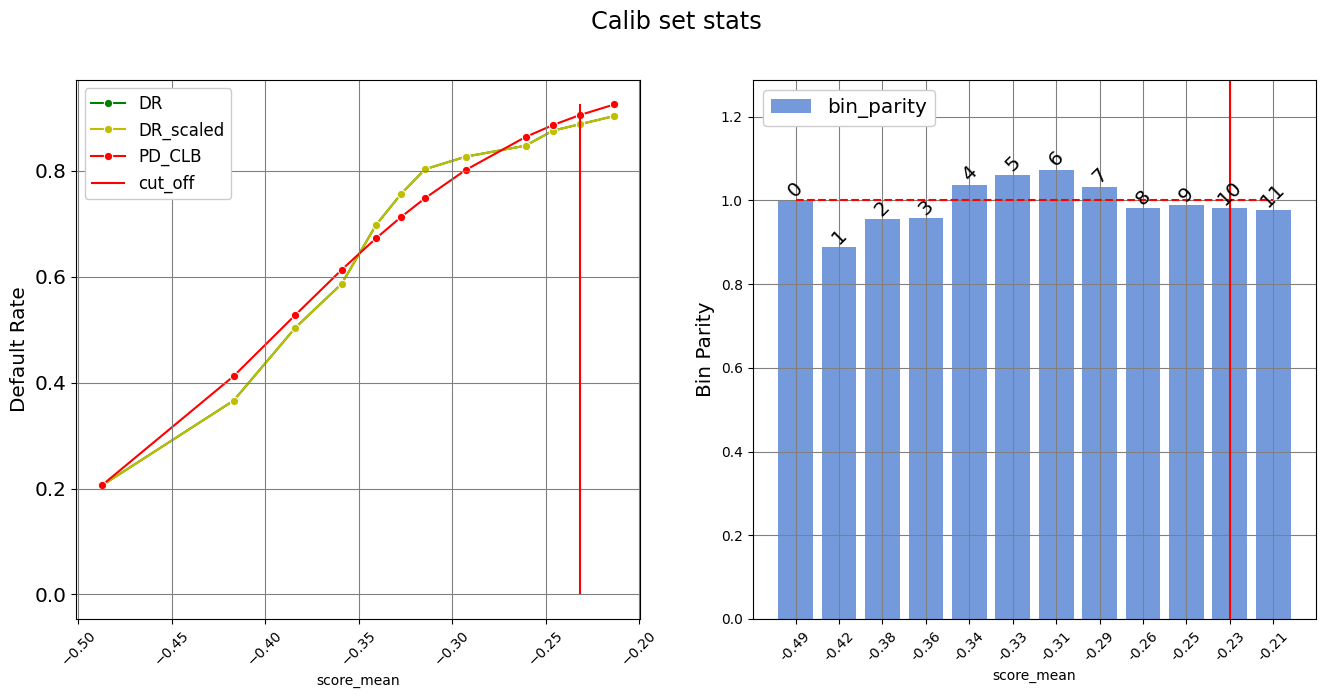

In [32]:
calib.plot_clb_building(gr_score)

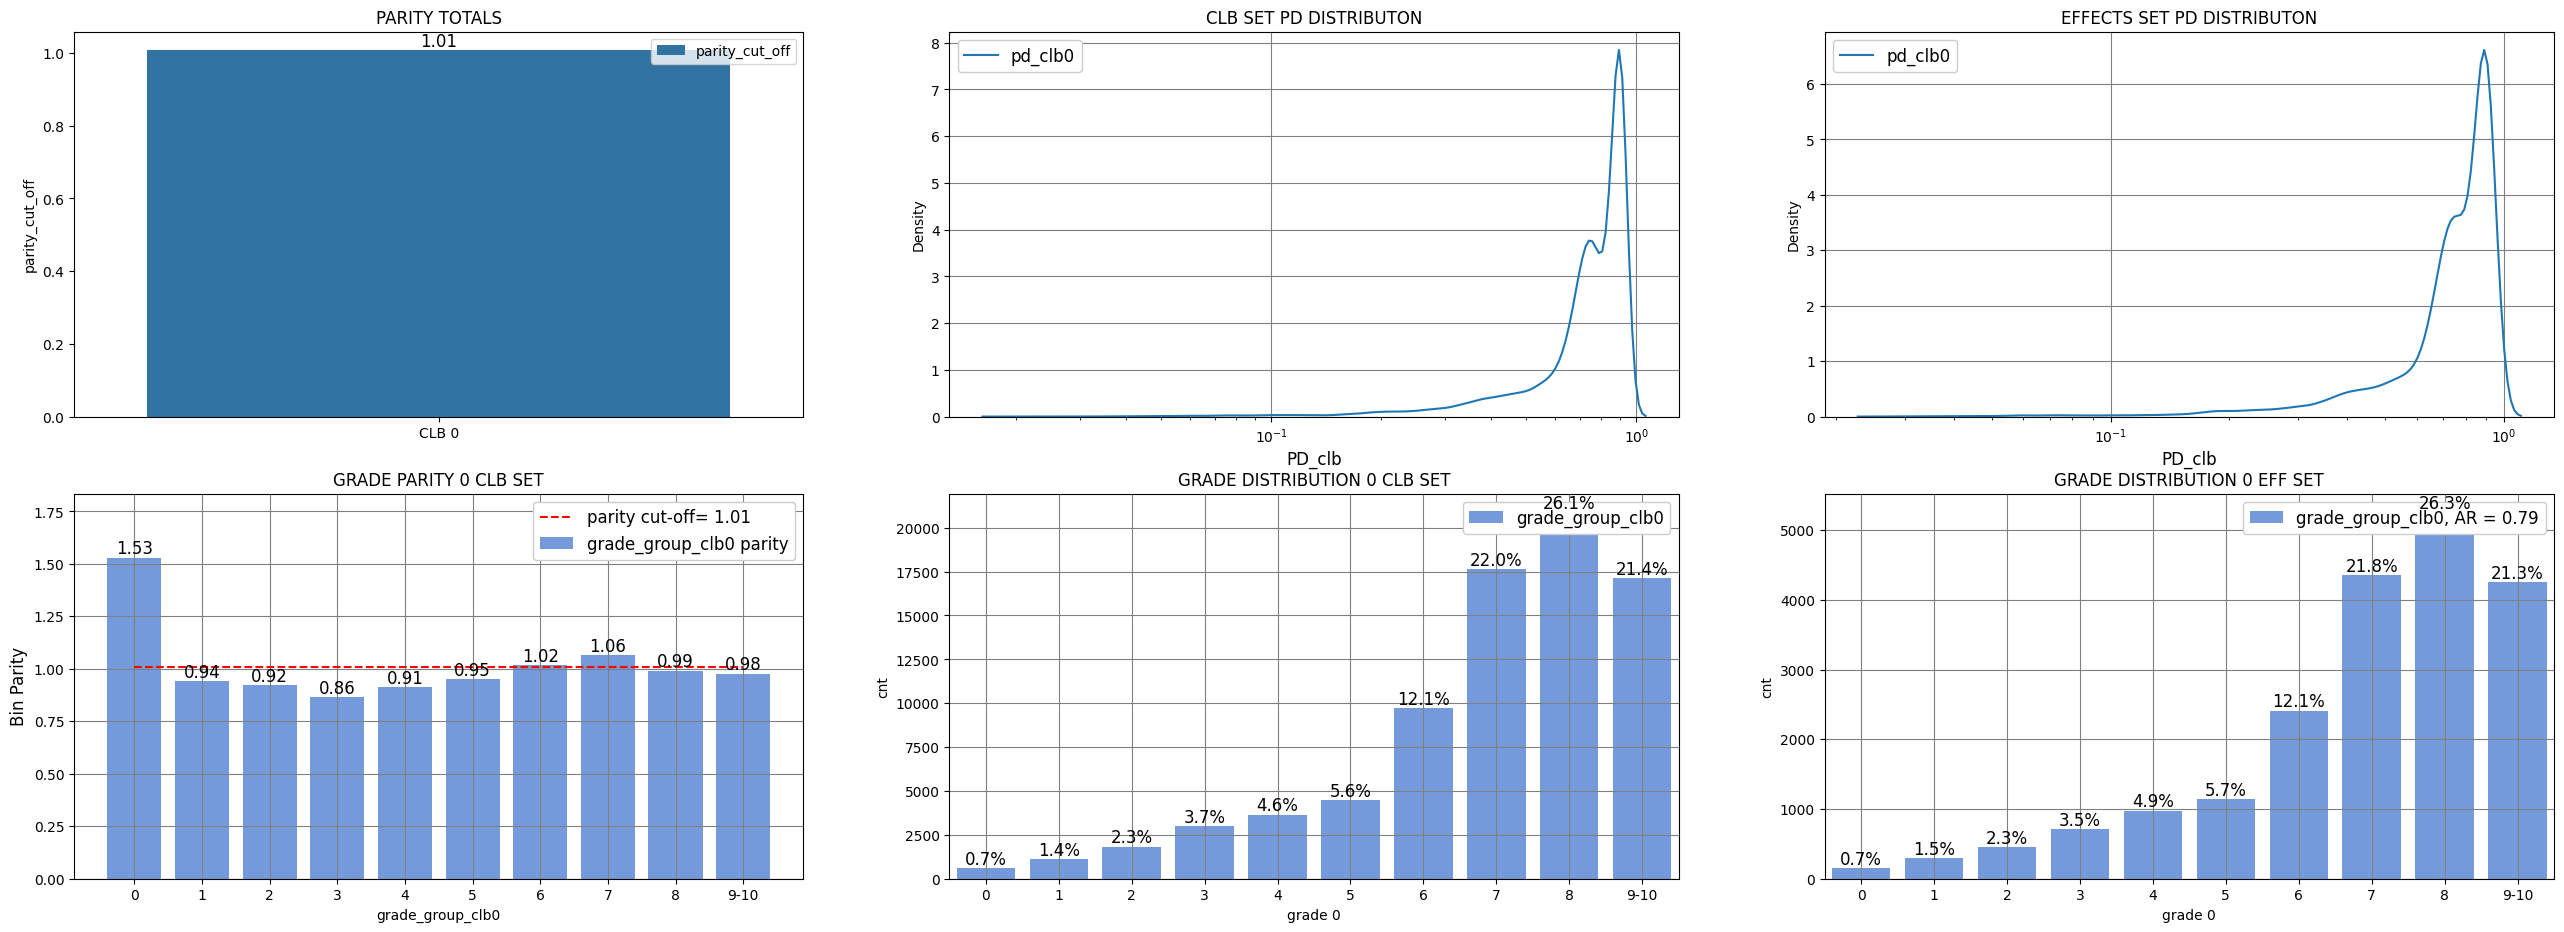

In [33]:
calib.plot_results([0])

In [34]:
calib.results

bins_name base_n  parity_issued  cut_off        b0         b1  \
0  optb_bins_0   None            1.0      0.9 -1.303592 -14.104753   

   score_median          a         b  parity_total  ...  1_eff_mix  2_eff_mix  \
0     -0.299303 -14.104753 -5.525183      0.999628  ...     0.0145     0.0227   

   3_eff_mix  4_eff_mix  5_eff_mix  6_eff_mix  7_eff_mix  8_eff_mix  \
0    0.03525     0.0488      0.057    0.12055     0.2179    0.26315   

   9-10_eff_mix  approve_rate  
0       0.21285       0.78715  

[1 rows x 42 columns]

In [35]:
a = -14.104753
b = -5.525183
df['score_calibrated'] = 1/(1+np.exp(a*df['score']+b))

# Трансформация калибровок(продвинутый уровень)

In [36]:
calib.transform_clb(clb_ind=0, cut_off_dr=0.9, stretch_k=1, shift=0)
calib.transform_clb(clb_ind=0, cut_off_dr=0.9, stretch_k=1.2, shift=0)
calib.transform_clb(clb_ind=0, cut_off_dr=0.9, stretch_k=1, shift=0.8)
calib.transform_clb(clb_ind=0, cut_off_dr=0.9, stretch_k=1, shift=0.2)
calib.transform_clb(clb_ind=0, cut_off_dr=0.9, stretch_k=1, shift=-0.2)

/content/./library/fgb/fgb/functions_layer/calibration/calibration_class.py:123: RuntimeWarning: invalid value encountered in scalar divide
  ,'parity_cut_off' : real_bads_cut_off / model_bads_cut_off
/content/./library/fgb/fgb/functions_layer/calibration/calibration_class.py:123: RuntimeWarning: invalid value encountered in scalar divide
  ,'parity_cut_off' : real_bads_cut_off / model_bads_cut_off
/content/./library/fgb/fgb/functions_layer/calibration/calibration_class.py:123: RuntimeWarning: invalid value encountered in scalar divide
  ,'parity_cut_off' : real_bads_cut_off / model_bads_cut_off
/content/./library/fgb/fgb/functions_layer/calibration/calibration_class.py:123: RuntimeWarning: invalid value encountered in scalar divide
  ,'parity_cut_off' : real_bads_cut_off / model_bads_cut_off


In [37]:
calib.results

bins_name base_n  parity_issued  cut_off        b0         b1  \
0  optb_bins_0   None            1.0      0.9 -1.303592 -14.104753   
1         None      0            NaN      0.9 -1.303592 -14.104753   
2         None      0            NaN      0.9 -1.303592 -16.925703   
3         None      0            NaN      0.9 -0.503592 -14.104753   
4         None      0            NaN      0.9 -1.103592 -14.104753   
5         None      0            NaN      0.9 -1.503592 -14.104753   

   score_median          a         b  parity_total  ...  1_eff_mix  2_eff_mix  \
0     -0.299303 -14.104753 -5.525183      0.999628  ...    0.01450    0.02270   
1     -0.299303 -14.104753 -5.525183      0.999628  ...    0.01450    0.02270   
2     -0.299303 -16.925703 -6.369501      1.015252  ...    0.02540    0.03095   
3     -0.299303 -14.104753 -4.725183      1.235628  ...    0.04015    0.06140   
4     -0.299303 -14.104753 -5.325183      1.045174  ...    0.02000    0.02735   
5     -0.299303 -14.104753 -5.725183      0.960797  ...    0.00895    0.01965   

   3_eff_mix  4_eff_mix  5_eff_mix  6_eff_mix  7_eff_mix  8_eff_mix  \
0    0.03525    0.04880    0.05700    0.12055    0.21790    0.26315   
1    0.03525    0.04880    0.05700    0.12055    0.21790    0.26315   
2    0.04370    0.04480    0.05385    0.12850    0.17910    0.19275   
3    0.06115    0.10135    0.17945    0.11285    0.20265    0.21950   
4    0.04750    0.05280    0.06685    0.17425    0.16655    0.33370   
5    0.02525    0.04455    0.05315    0.07700    0.22325    0.23320   

   9-10_eff_mix  approve_rate  
0       0.21285       0.78715  
1       0.21285       0.78715  
2       0.28685       0.71315  
3           NaN       1.00000  
4       0.10195       0.89805  
5       0.30910       0.69090  

[6 rows x 42 columns]

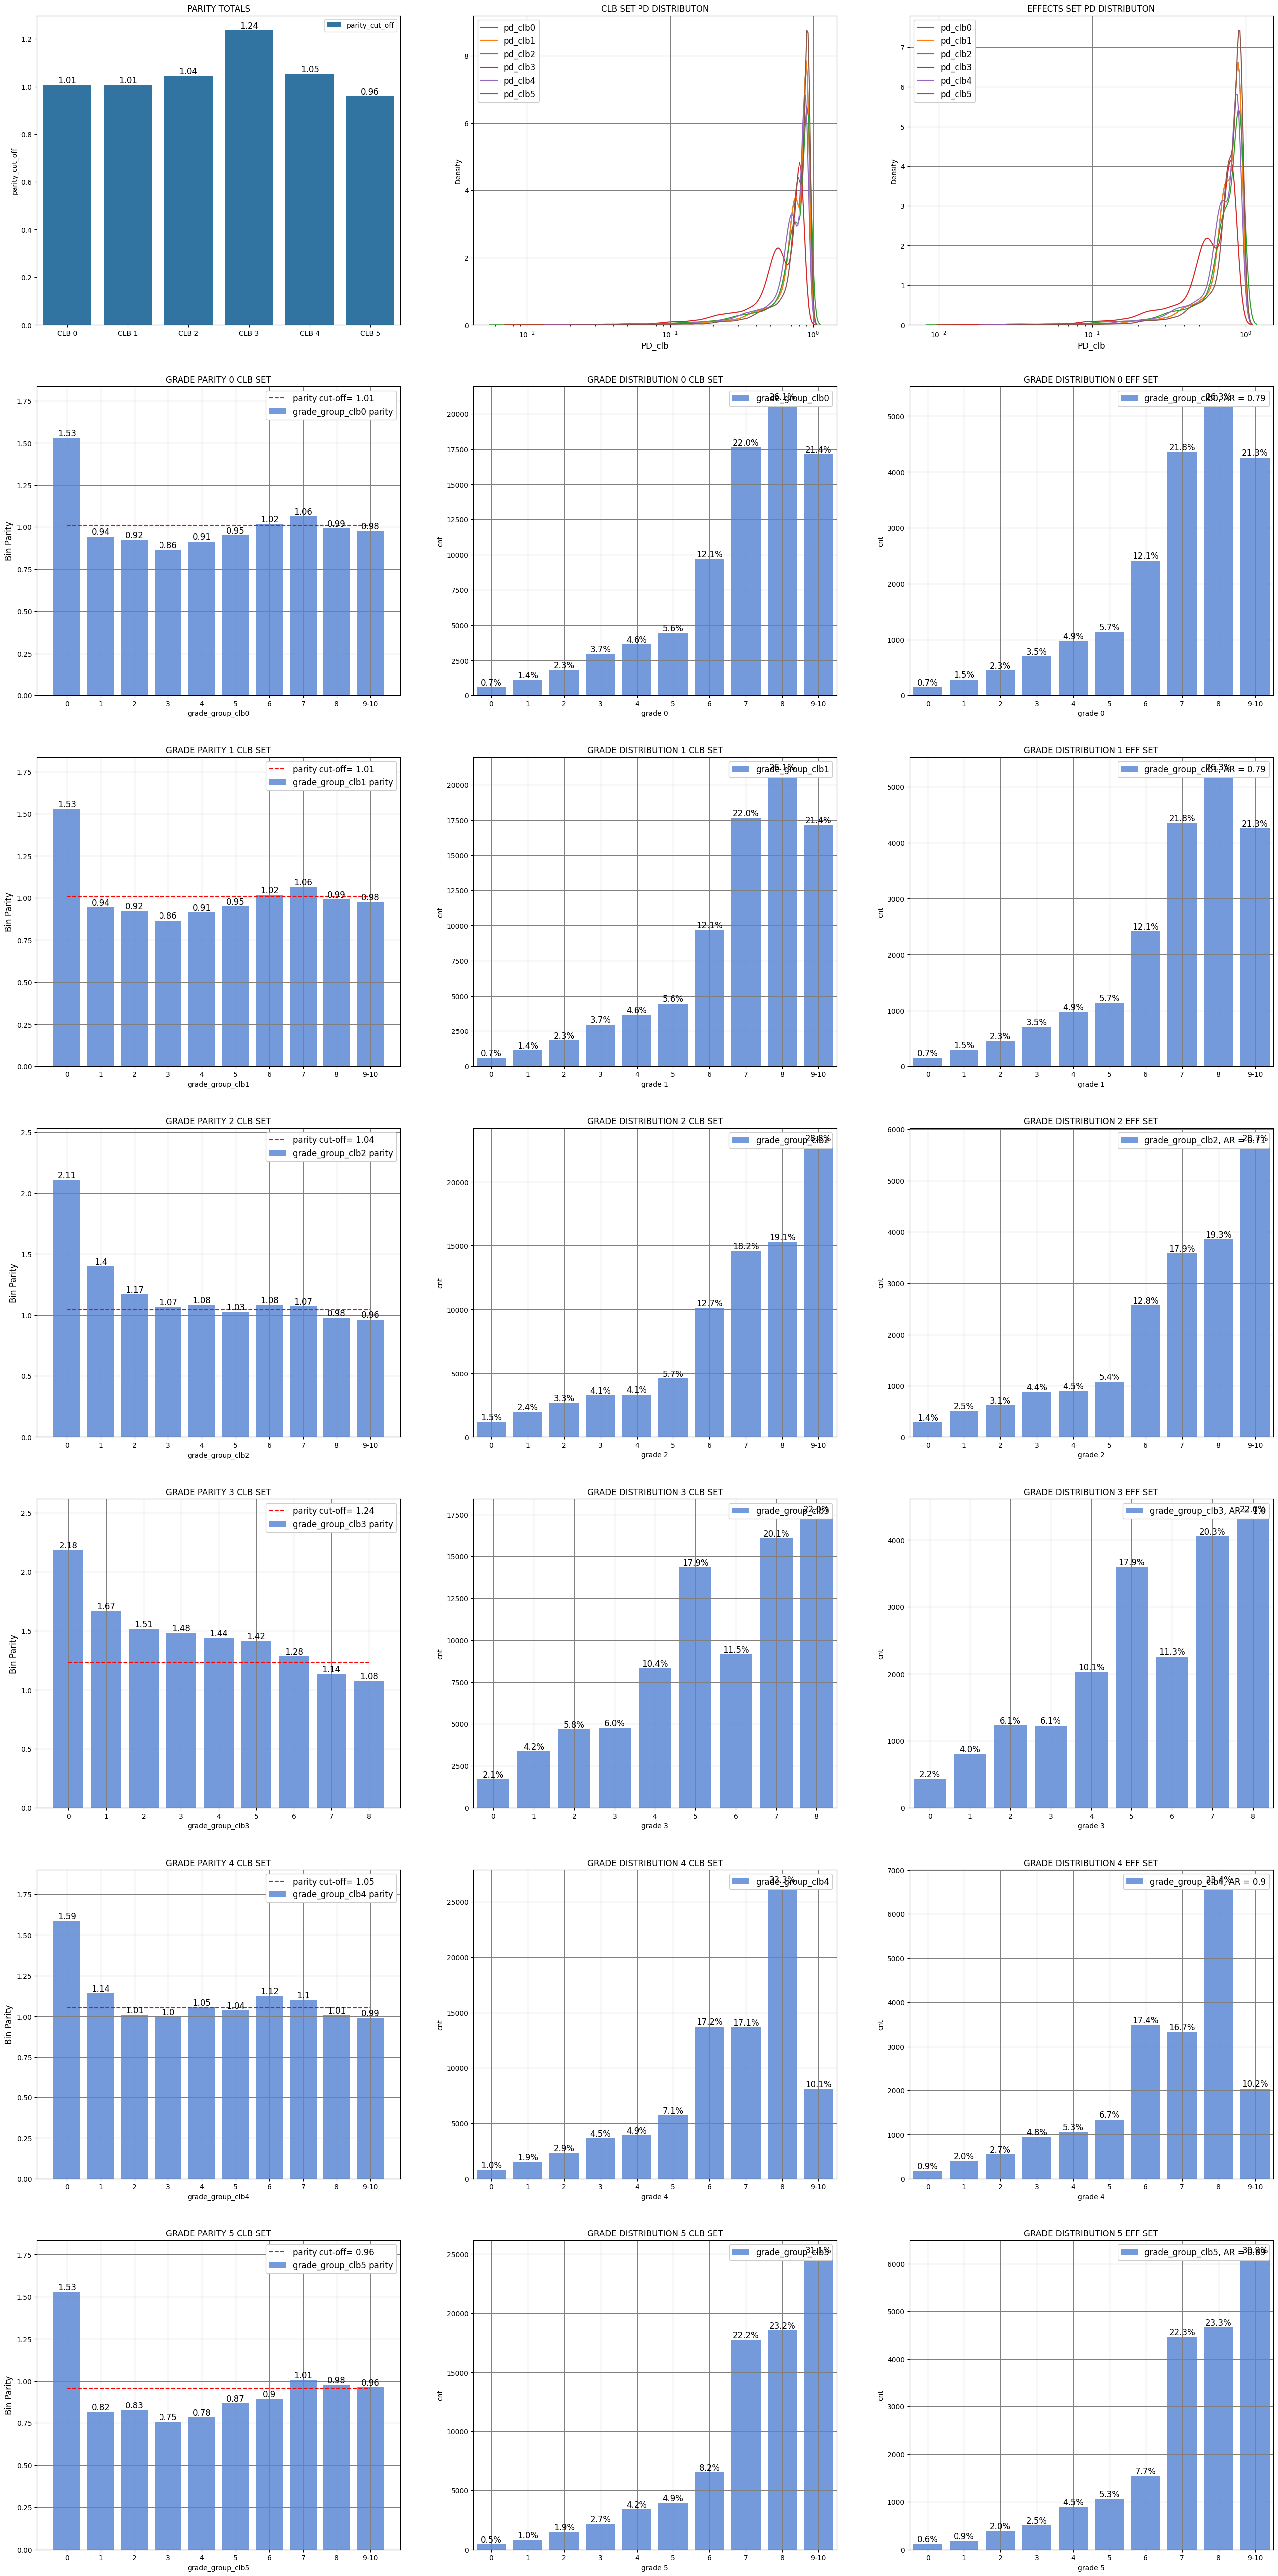

In [38]:
calib.plot_results([0,1,2,3,4,5])

# Калибровки с помощью стандартной библиотеки sklearn

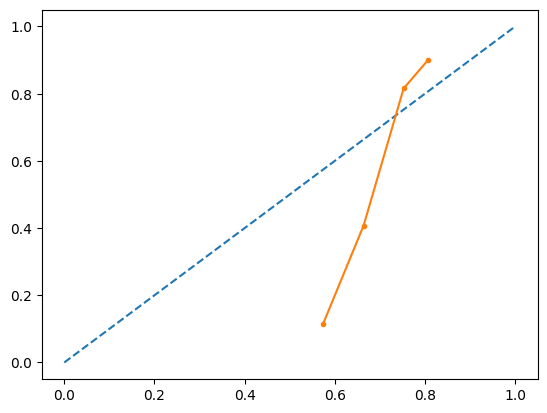

In [39]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# reliability diagram
fop, mpv = calibration_curve(df['target'], rfc.predict_proba(df[features])[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.', label='predict_proba')
plt.show()

In [40]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

svc_isotonic = CalibratedClassifierCV(rfc, cv=2, method="isotonic")
svc_sigmoid = CalibratedClassifierCV(rfc, cv=2, method="sigmoid")

In [41]:
svc_isotonic.fit(df[df['set_type'] == 'train'][features], df[df['set_type'] == 'train']['target'])
df['score_calibrated_isotonic'] = svc_isotonic.predict_proba(df[features])[:,1]

svc_sigmoid.fit(df[df['set_type'] == 'train'][features], df[df['set_type'] == 'train']['target'])
df['score_calibrated_sigmoid'] = svc_sigmoid.predict_proba(df[features])[:,1]

In [42]:
df[['score', 'score_calibrated','score_calibrated_isotonic', 'score_calibrated_sigmoid']]

score  score_calibrated  score_calibrated_isotonic  \
0     -0.241028          0.893361                   0.870403   
1     -0.426070          0.381208                   0.358914   
2     -0.246377          0.885957                   0.878651   
3     -0.276387          0.835733                   0.835176   
4     -0.246117          0.886327                   0.854798   
...         ...               ...                        ...   
99995 -0.331635          0.700054                   0.750139   
99996 -0.344045          0.662066                   0.662727   
99997 -0.226189          0.911722                   0.882807   
99998 -0.458353          0.280945                   0.270806   
99999 -0.316848          0.741948                   0.806069   

       score_calibrated_sigmoid  
0                      0.889850  
1                      0.398710  
2                      0.895740  
3                      0.830849  
4                      0.877037  
...                         ...  
99995                  0.703288  
99996                  0.654847  
99997                  0.904483  
99998                  0.322651  
99999                  0.750992  

[100000 rows x 4 columns]

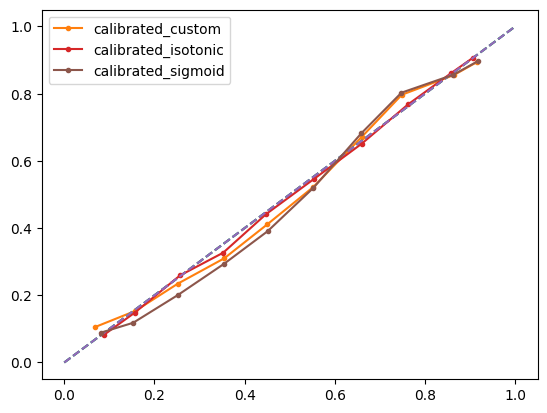

In [43]:
# reliability diagram
fop, mpv = calibration_curve(df['target'], df['score_calibrated'], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.', label='calibrated_custom')


fop, mpv = calibration_curve(df['target'], df['score_calibrated_isotonic'], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.', label='calibrated_isotonic')


fop, mpv = calibration_curve(df['target'], df['score_calibrated_sigmoid'], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.', label='calibrated_sigmoid')

plt.legend()
plt.show()

# Оценка калибровки

## Расчет метрики отличия реальных вероятностей в бине от тех что получились

на основе семинара https://www.youtube.com/live/IL7sWMOazXQ?si=xKJqI3lO1fFrRHiT

1.0439051988239005


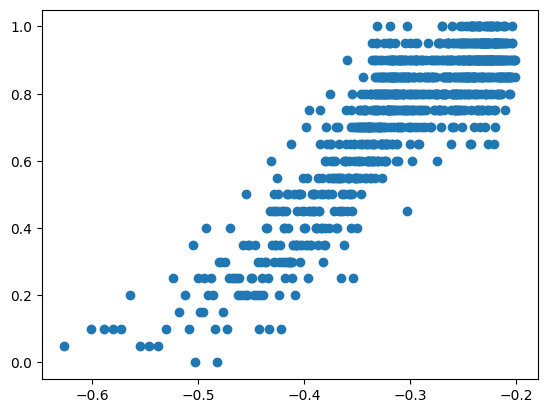

In [44]:
def give_ece_data(preds,bins,y_valid):
    sorted_ind = np.argsort(preds)
    predicted_bins = [[] for _ in range(bins)]
    actual_counters = [[] for _ in range(bins)]
    counters = [[] for _ in range(bins)]
    index = 0
    length_array = len(sorted_ind)
    step = 1.*length_array//bins
    for _ in range(bins):
        current = int(step*index)
        next_ = int(step*(index+1))
        predicted_bins[index] = np.mean(preds[sorted_ind[current:next_]])
        actual_counters[index] = np.mean(y_valid[sorted_ind[current:next_]])
        counters[index] = len(y_valid[sorted_ind[current:next_]])
        index += 1
    return predicted_bins,actual_counters,counters

bins = 1000
predicted_bins,actual_counters,counters = give_ece_data(df[df['set_type'] == 'test']['score'].reset_index(drop=True),bins,df[df['set_type'] == 'test']['target'].reset_index(drop=True))

plt.scatter(predicted_bins,actual_counters)
ece = 0
for i in range(bins):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(df[df['set_type'] == 'test'])
print(ece)

0.0751105362867521


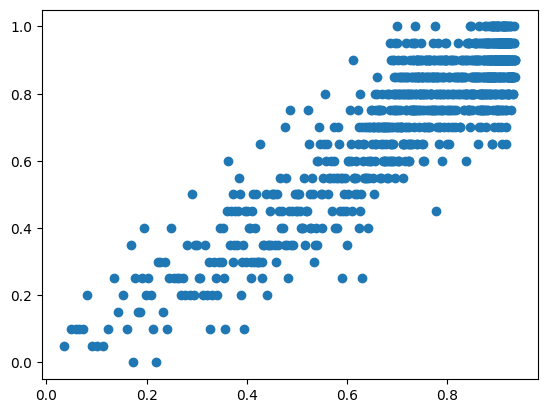

In [45]:
bins = 1000
predicted_bins,actual_counters,counters = give_ece_data(df[df['set_type'] == 'test']['score_calibrated'].reset_index(drop=True),bins,df[df['set_type'] == 'test']['target'].reset_index(drop=True))

plt.scatter(predicted_bins,actual_counters)
ece = 0
for i in range(bins):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(df[df['set_type'] == 'test'])
print(ece)

In [46]:
1/0.075

13.333333333333334

## Биноминальный тест двух распределений

In [47]:
df['score_calibrated_bins'] = df['score_calibrated'].apply(get_grade)
df['score_calibrated_bins_sklearn_isotonic'] = df['score_calibrated_isotonic'].apply(get_grade)
df['score_calibrated_bins_sklearn_sigmoid'] = df['score_calibrated_sigmoid'].apply(get_grade)

In [48]:
df[['target', 'score_calibrated', 'score_calibrated_bins', 'score_calibrated_isotonic', 'score_calibrated_sigmoid', 'score_calibrated_bins_sklearn_isotonic', 'score_calibrated_bins_sklearn_sigmoid']]

target  score_calibrated score_calibrated_bins  \
0           1          0.893361                     8   
1           1          0.381208                     3   
2           1          0.885957                     8   
3           1          0.835733                     8   
4           1          0.886327                     8   
...       ...               ...                   ...   
99995       0          0.700054                     7   
99996       1          0.662066                     6   
99997       1          0.911722                  9-10   
99998       0          0.280945                     2   
99999       1          0.741948                     7   

       score_calibrated_isotonic  score_calibrated_sigmoid  \
0                       0.870403                  0.889850   
1                       0.358914                  0.398710   
2                       0.878651                  0.895740   
3                       0.835176                  0.830849   
4                       0.854798                  0.877037   
...                          ...                       ...   
99995                   0.750139                  0.703288   
99996                   0.662727                  0.654847   
99997                   0.882807                  0.904483   
99998                   0.270806                  0.322651   
99999                   0.806069                  0.750992   

      score_calibrated_bins_sklearn_isotonic  \
0                                          8   
1                                          3   
2                                          8   
3                                          8   
4                                          8   
...                                      ...   
99995                                      7   
99996                                      6   
99997                                      8   
99998                                      2   
99999                                      8   

      score_calibrated_bins_sklearn_sigmoid  
0                                         8  
1                                         3  
2                                         8  
3                                         8  
4                                         8  
...                                     ...  
99995                                     7  
99996                                     6  
99997                                  9-10  
99998                                     3  
99999                                     7  

[100000 rows x 7 columns]

In [49]:
import scipy.stats as st

In [50]:
test = st.ttest_1samp(df['score'], popmean=-4567456745670000)
test.confidence_interval(confidence_level=0.95)

ConfidenceInterval(low=-0.3045737701381478, high=-0.3036518857201804)

In [51]:
def check(l,r,x):
  if (x>l) and (x<r):
    return True
  else:
    return False

def binominal_test_bins(df, actual_col, expected_col, binning_col, confidence=0.95):
    gr = df.groupby(by=binning_col)

    gr_table = gr.agg({expected_col:['count', 'sum', 'mean'], actual_col:['count', 'sum', 'mean']})
    gr_table.columns = [expected_col + '_count', expected_col + '_sum', expected_col + '_mean'] + [actual_col + '_count', actual_col + '_sum', actual_col + '_mean']
    gr_table = gr_table.reset_index()
    gr_table['parity'] = gr_table[expected_col + '_sum'] / gr_table[actual_col + '_sum']

    for g in gr.groups.keys():
      temp = gr.get_group(g)
      ttest_temp = st.ttest_1samp(temp[actual_col], popmean=temp[expected_col].mean())
      gr_table.loc[gr_table[binning_col] == g, 'ttest_p_value'] = ttest_temp.pvalue.round(4)
      ci = ttest_temp.confidence_interval(confidence_level=confidence)

      interval = st.t.interval(confidence=confidence
                              , df=len(temp[expected_col])-1
                              , loc=np.mean(temp[expected_col])
                              , scale=st.sem(temp[expected_col]))


      # print(ttest_temp.pvalue, ci, interval)

      gr_table.loc[gr_table[binning_col] == g, 't_interval_left'] = interval[0]
      gr_table.loc[gr_table[binning_col] == g, 't_interval_right'] = interval[1]

      interval = st.binom.interval(confidence=confidence
                            , n=len(temp[expected_col])
                            , p=np.mean(temp[expected_col]))

      gr_table.loc[gr_table[binning_col] == g, 'binom_interval_left'] = interval[0]
      gr_table.loc[gr_table[binning_col] == g, 'binom_interval_right'] = interval[1]

      # expected calibration error from 0 to 1
      gr_table['calibration_ece'] = (gr_table[expected_col + '_count'] / len(df)) * np.abs(gr_table[expected_col + '_mean'] - gr_table[actual_col + '_mean'])

      # check in interval tests
      gr_table['ttest_p_value_not_equal_res'] = gr_table['ttest_p_value'] < (1 - confidence) # если проходит то не равны
      gr_table['t_interval_res'] = gr_table[['t_interval_left', 't_interval_right', actual_col + '_mean']].apply(lambda x : check(x['t_interval_left'], x['t_interval_right'], x[actual_col+'_mean']), axis=1)
      gr_table['binom_interval_res'] = gr_table[['binom_interval_left', 'binom_interval_right', actual_col + '_sum']].apply(lambda x : check(x['binom_interval_left'], x['binom_interval_right'], x[actual_col+'_sum']), axis=1)

    return gr_table

binominal_test_bins(df[df['set_type'] == 'test'], actual_col='score', expected_col='target', binning_col='score_calibrated_bins')

score_calibrated_bins  target_count  target_sum  target_mean  score_count  \
0                     0           146          15     0.102740          146   
1                     1           290          51     0.175862          290   
2                     2           454         111     0.244493          454   
3                     3           705         229     0.324823          705   
4                     4           976         401     0.410861          976   
5                     5          1140         583     0.511404         1140   
6                     6          2411        1619     0.671506         2411   
7                     7          4358        3472     0.796696         4358   
8                     8          5263        4496     0.854266         5263   
9                  9-10          4257        3816     0.896406         4257   

     score_sum  score_mean    parity  ttest_p_value  t_interval_left  \
0   -85.041450   -0.582476 -0.176385            0.0         0.052905   
1  -147.889557   -0.509964 -0.344852            0.0         0.131786   
2  -212.925687   -0.468999 -0.521309            0.0         0.204810   
3  -305.800220   -0.433759 -0.748855            0.0         0.290170   
4  -396.420724   -0.406169 -1.011552            0.0         0.379941   
5  -430.018524   -0.377209 -1.355756            0.0         0.482343   
6  -830.442935   -0.344439 -1.949562            0.0         0.652745   
7 -1368.887321   -0.314109 -2.536367            0.0         0.784742   
8 -1364.488077   -0.259261 -3.295009            0.0         0.844730   
9  -943.189481   -0.221562 -4.045847            0.0         0.887248   

   t_interval_right  binom_interval_left  binom_interval_right  \
0          0.152574                  8.0                  23.0   
1          0.219939                 39.0                  64.0   
2          0.284177                 93.0                 129.0   
3          0.359476                205.0                 254.0   
4          0.441781                371.0                 431.0   
5          0.540464                550.0                 616.0   
6          0.690266               1574.0                1664.0   
7          0.808649               3420.0                3524.0   
8          0.863801               4445.0                4546.0   
9          0.905564               3777.0                3855.0   

   calibration_ece  ttest_p_value_not_equal_res  t_interval_res  \
0         0.005002                         True           False   
1         0.009944                         True           False   
2         0.016196                         True           False   
3         0.026740                         True           False   
4         0.039871                         True           False   
5         0.050651                         True           False   
6         0.122472                         True           False   
7         0.242044                         True           False   
8         0.293024                         True           False   
9         0.237959                         True           False   

   binom_interval_res  
0               False  
1               False  
2               False  
3               False  
4               False  
5               False  
6               False  
7               False  
8               False  
9               False

In [52]:
binominal_test_bins(df[df['set_type'] == 'test'], actual_col='score_calibrated', expected_col='target', binning_col='score_calibrated_bins')

score_calibrated_bins  target_count  target_sum  target_mean  \
0                     0           146          15     0.102740   
1                     1           290          51     0.175862   
2                     2           454         111     0.244493   
3                     3           705         229     0.324823   
4                     4           976         401     0.410861   
5                     5          1140         583     0.511404   
6                     6          2411        1619     0.671506   
7                     7          4358        3472     0.796696   
8                     8          5263        4496     0.854266   
9                  9-10          4257        3816     0.896406   

   score_calibrated_count  score_calibrated_sum  score_calibrated_mean  \
0                     146              9.672243               0.066248   
1                     290             46.682993               0.160976   
2                     454            114.762862               0.252782   
3                     705            251.319695               0.356482   
4                     976            438.630622               0.449417   
5                    1140            627.953712               0.550837   
6                    2411           1591.942123               0.660283   
7                    4358           3260.779880               0.748229   
8                    5263           4547.176412               0.863989   
9                    4257           3900.809068               0.916328   

     parity  ttest_p_value  t_interval_left  t_interval_right  \
0  1.550830            0.0         0.052905          0.152574   
1  1.092475            0.0         0.131786          0.219939   
2  0.967212            0.0         0.204810          0.284177   
3  0.911190            0.0         0.290170          0.359476   
4  0.914209            0.0         0.379941          0.441781   
5  0.928412            0.0         0.482343          0.540464   
6  1.016997            0.0         0.652745          0.690266   
7  1.064776            0.0         0.784742          0.808649   
8  0.988745            0.0         0.844730          0.863801   
9  0.978259            0.0         0.887248          0.905564   

   binom_interval_left  binom_interval_right  calibration_ece  \
0                  8.0                  23.0         0.000266   
1                 39.0                  64.0         0.000216   
2                 93.0                 129.0         0.000188   
3                205.0                 254.0         0.001116   
4                371.0                 431.0         0.001882   
5                550.0                 616.0         0.002248   
6               1574.0                1664.0         0.001353   
7               3420.0                3524.0         0.010561   
8               4445.0                4546.0         0.002559   
9               3777.0                3855.0         0.004240   

   ttest_p_value_not_equal_res  t_interval_res  binom_interval_res  
0                         True            True                True  
1                         True            True                True  
2                         True            True                True  
3                         True            True                True  
4                         True           False               False  
5                         True           False               False  
6                         True            True                True  
7                         True           False               False  
8                         True           False               False  
9                         True           False               False

In [53]:
binominal_test_bins(df[df['set_type'] == 'test'], actual_col='score_calibrated_isotonic', expected_col='target', binning_col='score_calibrated_bins_sklearn_isotonic')

score_calibrated_bins_sklearn_isotonic  target_count  target_sum  \
0                                      0            53           5   
1                                      1           476          72   
2                                      2           528         149   
3                                      3           804         271   
4                                      4          1074         484   
5                                      5          1093         578   
6                                      6          1208         769   
7                                      7          3334        2599   
8                                      8         10246        8805   
9                                   9-10          1184        1061   

   target_mean  score_calibrated_isotonic_count  \
0     0.094340                               53   
1     0.151261                              476   
2     0.282197                              528   
3     0.337065                              804   
4     0.450652                             1074   
5     0.528820                             1093   
6     0.636589                             1208   
7     0.779544                             3334   
8     0.859360                            10246   
9     0.896115                             1184   

   score_calibrated_isotonic_sum  score_calibrated_isotonic_mean    parity  \
0                       4.560031                        0.086038  1.096484   
1                      75.296157                        0.158185  0.956224   
2                     135.343251                        0.256332  1.100905   
3                     283.746843                        0.352919  0.955077   
4                     481.215286                        0.448059  1.005787   
5                     605.396114                        0.553885  0.954747   
6                     797.407527                        0.660106  0.964375   
7                    2540.143366                        0.761891  1.023171   
8                    8782.533121                        0.857167  1.002558   
9                    1073.542237                        0.906708  0.988317   

   ttest_p_value  t_interval_left  t_interval_right  binom_interval_left  \
0         0.0081         0.013001          0.175679                  1.0   
1         0.0000         0.118956          0.183565                 57.0   
2         0.0000         0.243683          0.320711                129.0   
3         0.0000         0.304320          0.369809                245.0   
4         0.0061         0.420847          0.480456                452.0   
5         0.0000         0.499181          0.558459                546.0   
6         0.0000         0.609428          0.663751                736.0   
7         0.0000         0.765465          0.793623               2552.0   
8         0.0000         0.852627          0.866092               8736.0   
9         0.0000         0.878710          0.913519               1040.0   

   binom_interval_right  calibration_ece  ttest_p_value_not_equal_res  \
0                   9.0         0.000022                         True   
1                  88.0         0.000165                         True   
2                 169.0         0.000683                         True   
3                 297.0         0.000637                         True   
4                 516.0         0.000139                         True   
5                 610.0         0.001370                         True   
6                 802.0         0.001420                         True   
7                2646.0         0.002943                         True   
8                8874.0         0.001123                         True   
9                1081.0         0.000627                         True   

   t_interval_res  binom_interval_res  
0            True                True  
1            True                True  
2            True                True  
3        

In [54]:
binominal_test_bins(df[df['set_type'] == 'test'], actual_col='score_calibrated_sigmoid', expected_col='target', binning_col='score_calibrated_bins_sklearn_sigmoid')

score_calibrated_bins_sklearn_sigmoid  target_count  target_sum  \
0                                     0            54           5   
1                                     1           209          24   
2                                     2           470          99   
3                                     3           702         217   
4                                     4          1100         434   
5                                     5          1252         643   
6                                     6          2577        1757   
7                                     7          4373        3504   
8                                     8          5095        4363   
9                                  9-10          4168        3747   

   target_mean  score_calibrated_sigmoid_count  score_calibrated_sigmoid_sum  \
0     0.092593                              54                      4.327622   
1     0.114833                             209                     31.283684   
2     0.210638                             470                    117.956503   
3     0.309117                             702                    249.131635   
4     0.394545                            1100                    496.548204   
5     0.513578                            1252                    690.292298   
6     0.681801                            2577                   1699.243372   
7     0.801281                            4373                   3269.228316   
8     0.856330                            5095                   4398.592085   
9     0.898992                            4168                   3824.077829   

   score_calibrated_sigmoid_mean    parity  ttest_p_value  t_interval_left  \
0                       0.080141  1.155369            0.0         0.012733   
1                       0.149683  0.767173            0.0         0.071252   
2                       0.250971  0.839292            0.0         0.173639   
3                       0.354888  0.871025            0.0         0.274848   
4                       0.451407  0.874034            0.0         0.365618   
5                       0.551352  0.931489            0.0         0.485855   
6                       0.659388  1.033990            0.0         0.663805   
7                       0.747594  1.071813            0.0         0.789449   
8                       0.863315  0.991908            0.0         0.846695   
9                       0.917485  0.979844            0.0         0.889840   

   t_interval_right  binom_interval_left  binom_interval_right  \
0          0.172452                  1.0                  10.0   
1          0.158413                 15.0                  33.0   
2          0.247637                 82.0                 117.0   
3          0.343386                193.0                 241.0   
4          0.423473                402.0                 466.0   
5          0.541302                608.0                 678.0   
6          0.699796               1710.0                1803.0   
7          0.813112               3452.0                3555.0   
8          0.865964               4314.0                4412.0   
9          0.908144               3708.0                3785.0   

   calibration_ece  ttest_p_value_not_equal_res  t_interval_res  \
0         0.000034                         True            True   
1         0.000364                         True            True   
2         0.000948                         True           False   
3         0.001607                         True           False   
4         0.003127                         True           False   
5         0.002365                         True           False   
6         0.002888                         True           False   
7         0.011739                         True           False   
8         0.001780                         True            True   
9         0.003854                         True           False   

   binom_interval_res  
0            

как мы видем столбцы проверки t_interval_res и binom_interval_res имеют в своем составе и False, чего не должно быть

Здесь могут быть три причины:

1.   Мы плохо откалибровались
2.   Выбрана неподходящая мастер-шкала
3.   Модель плохо делит на нужных бинах

Решения, делятся на два подхода:


#переписать подходы на дерево от минимально трудоемкого к самому трудоемкому




**Первый** - это в случае если менять мастер шкалу нельзя, и нет ошибки в коде,
значит либо модель плохо делит на необходимых бинах шкалы, либо мы не совсем верно выбираем интервал где калибруемся и оцениваем их правильность. **Тогда либо необходимо улучшить модель, либо подобрать другой интервал калибровки оценки эффектов**

**Второй** - это ошибка в выборе мастер шкалы, например слишком высокая детализация в пустых сегментах, **тогда меняем саму мастер шкалу**

В нашей ситуации, мы видим что мастер шкала плохо ему подходит и хотя её можно использовать, но ряд бинов все равно проваливается за её пределы

# Подберем разными способами мастер шкалу

## Изотоническое разбиение

строим изотонику

In [55]:
from sklearn.isotonic import IsotonicRegression
iso_reg = IsotonicRegression().fit(df[df['set_type'] == 'train']['score'], df[df['set_type'] == 'train']['target'])
df['master_scale_1_isotonic'] = iso_reg.predict(df['score'])

<Axes: xlabel='master_scale_1_isotonic', ylabel='Density'>

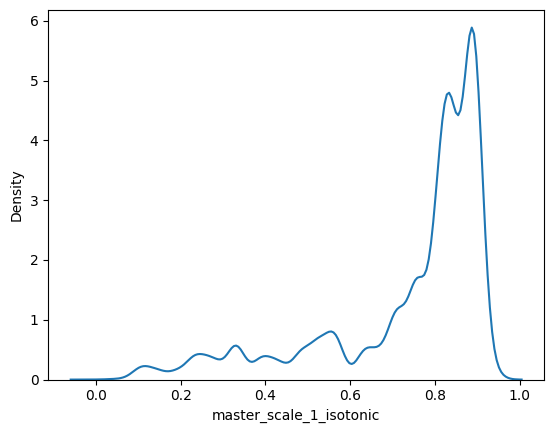

In [56]:
sns.kdeplot(df['master_scale_1_isotonic'])

так как она получается очень детальная, схлопываем бины до тех пор пока они не станут проходить тесты

In [57]:
from optbinning import OptimalBinning
optb = OptimalBinning(name='master_scale_1_isotonic', dtype="numerical", solver="cp", monotonic_trend='auto_asc_desc', min_event_rate_diff=0.05)
optb.fit(df[df['set_type'] == 'train']['master_scale_1_isotonic'] , df[df['set_type'] == 'train']['target'])
df['master_scale_1_isotonic_optb_bins'] = optb.transform(df['master_scale_1_isotonic'], metric="event_rate")

optb.binning_table.build()

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.37)   7082   0.088525       5325   1757    0.248094   
1       [0.37, 0.50)   4049   0.050612       2270   1779    0.439368   
2       [0.50, 0.62)   5088   0.063600       2306   2782    0.546777   
3       [0.62, 0.71)   5050   0.063125       1669   3381    0.669505   
4       [0.71, 0.79)   8861   0.110762       2235   6626    0.747771   
5       [0.79, 0.86)  23762   0.297025       4129  19633    0.826235   
6        [0.86, inf)  26108   0.326350       2887  23221    0.889421   
7            Special      0   0.000000          0      0    0.000000   
8            Missing      0   0.000000          0      0    0.000000   
Totals                80000   1.000000      20821  59179    0.739738   

             WoE        IV        JS  
0        2.15341  0.486804  0.051284  
1       1.288333  0.101731  0.011904  
2       0.856949  0.054625  0.006627  
3       0.338658  0.007799  0.000970  
4      -0.042155  0.000195  0.000024  
5      -0.514572  0.068668  0.008490  
6      -1.040234  0.263936  0.031581  
7            0.0  0.000000  0.000000  
8            0.0  0.000000  0.000000  
Totals            0.983757  0.110880

<Axes: xlabel='master_scale_1_isotonic_optb_bins', ylabel='Density'>

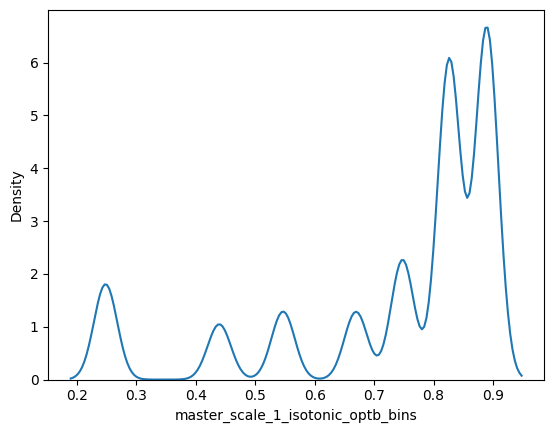

In [58]:
sns.kdeplot(df['master_scale_1_isotonic_optb_bins'])

In [59]:
binominal_test_bins(df[df['set_type'] == 'train'], actual_col='master_scale_1_isotonic', expected_col='target', binning_col='master_scale_1_isotonic_optb_bins')

master_scale_1_isotonic_optb_bins  target_count  target_sum  target_mean  \
0                           0.248094          7082        1757     0.248094   
1                           0.439368          4049        1779     0.439368   
2                           0.546777          5088        2782     0.546777   
3                           0.669505          5050        3381     0.669505   
4                           0.747771          8861        6626     0.747771   
5                           0.826235         23762       19633     0.826235   
6                           0.889421         26108       23221     0.889421   

   master_scale_1_isotonic_count  master_scale_1_isotonic_sum  \
0                           7082                       1757.0   
1                           4049                       1779.0   
2                           5088                       2782.0   
3                           5050                       3381.0   
4                           8861                       6626.0   
5                          23762                      19633.0   
6                          26108                      23221.0   

   master_scale_1_isotonic_mean  parity  ttest_p_value  t_interval_left  \
0                      0.248094     1.0            1.0         0.238032   
1                      0.439368     1.0            1.0         0.424074   
2                      0.546777     1.0            1.0         0.533094   
3                      0.669505     1.0            1.0         0.656527   
4                      0.747771     1.0            1.0         0.738727   
5                      0.826235     1.0            1.0         0.821417   
6                      0.889421     1.0            1.0         0.885617   

   t_interval_right  binom_interval_left  binom_interval_right  \
0          0.258155               1686.0                1828.0   
1          0.454661               1717.0                1841.0   
2          0.560460               2712.0                2852.0   
3          0.682483               3315.0                3446.0   
4          0.756815               6546.0                6706.0   
5          0.831053              19518.0               19747.0   
6          0.893225              23121.0               23320.0   

   calibration_ece  ttest_p_value_not_equal_res  t_interval_res  \
0     0.000000e+00                        False            True   
1     0.000000e+00                        False            True   
2     7.061018e-18                        False            True   
3     0.000000e+00                        False            True   
4     0.000000e+00                        False            True   
5     0.000000e+00                        False            True   
6     0.000000e+00                        False            True   

   binom_interval_res  
0                True  
1                True  
2                True  
3                True  
4                True  
5                True  
6                True

In [60]:
binominal_test_bins(df[df['set_type'] == 'test'], actual_col='master_scale_1_isotonic', expected_col='target', binning_col='master_scale_1_isotonic_optb_bins')

master_scale_1_isotonic_optb_bins  target_count  target_sum  target_mean  \
0                           0.248094          1772         472     0.266366   
1                           0.439368          1087         473     0.435143   
2                           0.546777          1227         670     0.546047   
3                           0.669505          1240         809     0.652419   
4                           0.747771          2253        1691     0.750555   
5                           0.826235          5906        4872     0.824924   
6                           0.889421          6515        5806     0.891174   

   master_scale_1_isotonic_count  master_scale_1_isotonic_sum  \
0                           1772                   441.970202   
1                           1087                   479.129979   
2                           1227                   670.226953   
3                           1240                   831.560544   
4                           2253                  1684.031688   
5                           5906                  4880.265717   
6                           6515                  5794.211604   

   master_scale_1_isotonic_mean    parity  ttest_p_value  t_interval_left  \
0                      0.249419  1.067945         0.0000         0.245763   
1                      0.440782  0.987206         0.0000         0.405624   
2                      0.546232  0.999661         0.7558         0.518151   
3                      0.670613  0.972870         0.0000         0.625878   
4                      0.747462  1.004138         0.0000         0.732674   
5                      0.826323  0.998306         0.0000         0.815229   
6                      0.889365  1.002035         0.0000         0.883610   

   t_interval_right  binom_interval_left  binom_interval_right  \
0          0.286968                436.0                 509.0   
1          0.464662                441.0                 505.0   
2          0.573944                636.0                 704.0   
3          0.678961                776.0                 842.0   
4          0.768435               1651.0                1731.0   
5          0.834619               4814.0                4929.0   
6          0.898738               5756.0                5855.0   

   calibration_ece  ttest_p_value_not_equal_res  t_interval_res  \
0         0.001501                         True            True   
1         0.000306                         True            True   
2         0.000011                        False            True   
3         0.001128                         True            True   
4         0.000348                         True            True   
5         0.000413                         True            True   
6         0.000589                         True            True   

   binom_interval_res  
0                True  
1                True  
2                True  
3                True  
4                True  
5                True  
6                True

## Только optbinning

In [61]:
from optbinning import OptimalBinning
optb = OptimalBinning(name='score', dtype="numerical", solver="cp", monotonic_trend='auto_asc_desc', min_event_rate_diff=0.05)
optb.fit(df[df['set_type'] == 'train']['score'] , df[df['set_type'] == 'train']['target'])
df['master_scale_2_optb_bins'] = optb.transform(df['score'], metric="event_rate")

optb.binning_table.build()

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, -0.42)   7082   0.088525       5325   1757    0.248094   
1       [-0.42, -0.38)   4049   0.050612       2270   1779    0.439368   
2       [-0.38, -0.36)   5088   0.063600       2306   2782    0.546777   
3       [-0.36, -0.34)   5050   0.063125       1669   3381    0.669505   
4       [-0.34, -0.32)   8861   0.110762       2235   6626    0.747771   
5       [-0.32, -0.25)  23762   0.297025       4129  19633    0.826235   
6         [-0.25, inf)  26108   0.326350       2887  23221    0.889421   
7              Special      0   0.000000          0      0    0.000000   
8              Missing      0   0.000000          0      0    0.000000   
Totals                  80000   1.000000      20821  59179    0.739738   

             WoE        IV        JS  
0        2.15341  0.486804  0.051284  
1       1.288333  0.101731  0.011904  
2       0.856949  0.054625  0.006627  
3       0.338658  0.007799  0.000970  
4      -0.042155  0.000195  0.000024  
5      -0.514572  0.068668  0.008490  
6      -1.040234  0.263936  0.031581  
7            0.0  0.000000  0.000000  
8            0.0  0.000000  0.000000  
Totals            0.983757  0.110880

In [62]:
binominal_test_bins(df[df['set_type'] == 'train'], actual_col='master_scale_2_optb_bins', expected_col='target', binning_col='master_scale_2_optb_bins')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment 

master_scale_2_optb_bins  target_count  target_sum  target_mean  \
0                  0.248094          7082        1757     0.248094   
1                  0.439368          4049        1779     0.439368   
2                  0.546777          5088        2782     0.546777   
3                  0.669505          5050        3381     0.669505   
4                  0.747771          8861        6626     0.747771   
5                  0.826235         23762       19633     0.826235   
6                  0.889421         26108       23221     0.889421   

   master_scale_2_optb_bins_count  master_scale_2_optb_bins_sum  \
0                            7082                        1757.0   
1                            4049                        1779.0   
2                            5088                        2782.0   
3                            5050                        3381.0   
4                            8861                        6626.0   
5                           23762                       19633.0   
6                           26108                       23221.0   

   master_scale_2_optb_bins_mean  parity  ttest_p_value  t_interval_left  \
0                       0.248094     1.0            NaN         0.238032   
1                       0.439368     1.0            0.0         0.424074   
2                       0.546777     1.0            NaN         0.533094   
3                       0.669505     1.0            NaN         0.656527   
4                       0.747771     1.0            0.0         0.738727   
5                       0.826235     1.0            0.0         0.821417   
6                       0.889421     1.0            NaN         0.885617   

   t_interval_right  binom_interval_left  binom_interval_right  \
0          0.258155               1686.0                1828.0   
1          0.454661               1717.0                1841.0   
2          0.560460               2712.0                2852.0   
3          0.682483               3315.0                3446.0   
4          0.756815               6546.0                6706.0   
5          0.831053              19518.0               19747.0   
6          0.893225              23121.0               23320.0   

   calibration_ece  ttest_p_value_not_equal_res  t_interval_res  \
0              0.0                        False            True   
1              0.0                         True            True   
2              0.0                        False            True   
3              0.0                        False            True   
4              0.0                         True            True   
5              0.0                         True            True   
6              0.0                        False            True   

   binom_interval_res  
0                True  
1                True  
2                True  
3                True  
4                True  
5                True  
6                True

In [63]:
binominal_test_bins(df[df['set_type'] == 'test'], actual_col='master_scale_2_optb_bins', expected_col='target', binning_col='master_scale_2_optb_bins')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment 

master_scale_2_optb_bins  target_count  target_sum  target_mean  \
0                  0.248094          1772         472     0.266366   
1                  0.439368          1087         473     0.435143   
2                  0.546777          1227         670     0.546047   
3                  0.669505          1240         809     0.652419   
4                  0.747771          2253        1691     0.750555   
5                  0.826235          5906        4872     0.824924   
6                  0.889421          6515        5806     0.891174   

   master_scale_2_optb_bins_count  master_scale_2_optb_bins_sum  \
0                            1772                    439.622141   
1                            1087                    477.592739   
2                            1227                    670.895047   
3                            1240                    830.186139   
4                            2253                   1684.728360   
5                            5906                   4879.744887   
6                            6515                   5794.576950   

   master_scale_2_optb_bins_mean    parity  ttest_p_value  t_interval_left  \
0                       0.248094  1.073649            0.0         0.245763   
1                       0.439368  0.990384            0.0         0.405624   
2                       0.546777  0.998666            0.0         0.518151   
3                       0.669505  0.974480            0.0         0.625878   
4                       0.747771  1.003723            0.0         0.732674   
5                       0.826235  0.998413            0.0         0.815229   
6                       0.889421  1.001971            0.0         0.883610   

   t_interval_right  binom_interval_left  binom_interval_right  \
0          0.286968                436.0                 509.0   
1          0.464662                441.0                 505.0   
2          0.573944                636.0                 704.0   
3          0.678961                776.0                 842.0   
4          0.768435               1651.0                1731.0   
5          0.834619               4814.0                4929.0   
6          0.898738               5756.0                5855.0   

   calibration_ece  ttest_p_value_not_equal_res  t_interval_res  \
0         0.001619                         True            True   
1         0.000230                         True            True   
2         0.000045                         True            True   
3         0.001059                         True            True   
4         0.000314                         True            True   
5         0.000387                         True            True   
6         0.000571                         True            True   

   binom_interval_res  
0                True  
1                True  
2                True  
3                True  
4                True  
5                True  
6                True